In [1]:
import torch
import my_utils as mu
import pandas as pd
import torch.utils.data as data
from torch import nn
import numpy as np
from numpy import linalg

D:\Python3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'D:\Python3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


# Neural Networks ECS659P Revision Elliot Linsey

### Human Intelligence: 
* Skills - languages, chess, mathematical reasoning
* Cognition - perception, memory, judgement and reasoning
* Volition - The will, purpose, choice
* Emotion - affective intelligence
* Speed, efficiency and creativity of information processing

Still very far away from achieving a machine that contains these qualities! 

Gary Marcus - "Today's AI has been very successful in building systems that perform a single narrow goal extremely well!"

For example, playing chess or identifying dog breeds or any other kind of pattern recognition

### The Deep Learning Model

Similar in training to standard machine learning. We use labelled input training data to create predictions or classifications. 

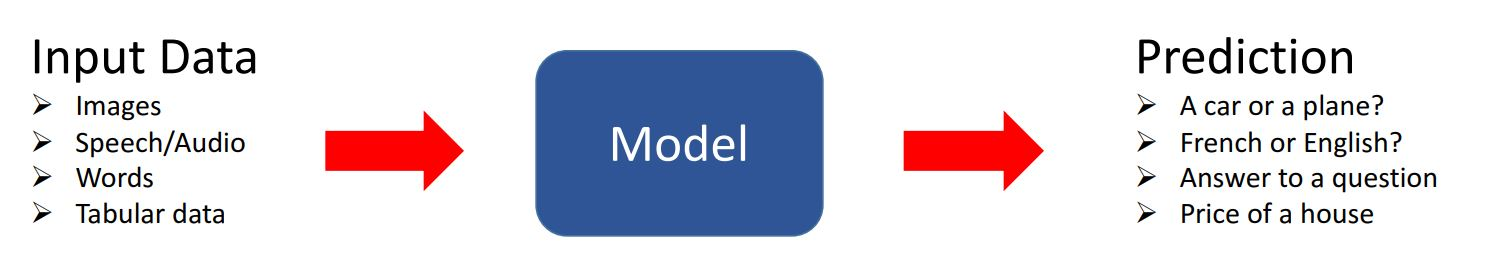

Within this, the model contains parameters (weights) which we compute functions or combinations of input data to make predictions.

For a linear regression model, the parameters would be: 

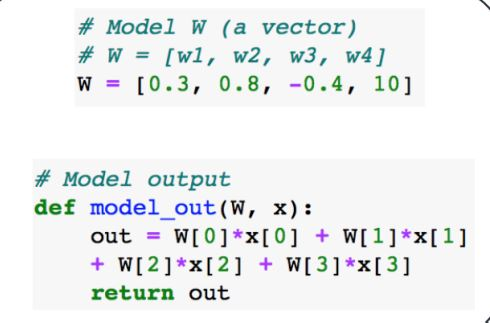

These are different to **Hyperparameters**.

### Training the Model

We always start with random values for our parameters, then update them so that our model predictions are as **close as possible** to the real outputs. 

We then define a **loss** function which determines how close to the true value our prediction is. 

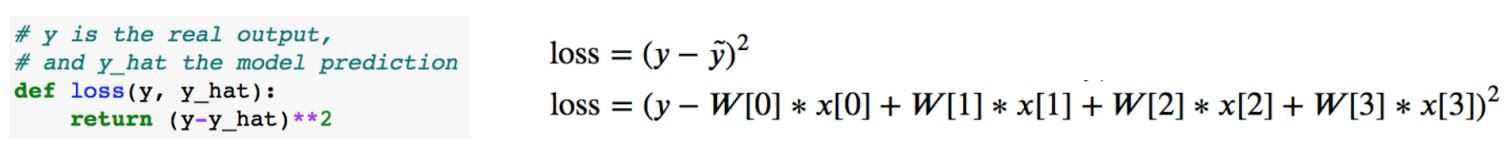

From here, **each parameter** is updated using the **derivative of the loss** in respect to that parameter.

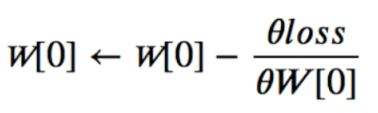

PyTorch takes care of this for us automatically, therefore I will skip any explicit maths to do with this subject (differential calculus) as I don't fully understand it (I have a music degree). 

## Multiple Linear Regression Example

Below is a dataframe full of fish with different species and some features regarding them (I have removed the species names). 

In [2]:
df = pd.read_csv('Fish.csv')
df = df.drop(columns='Species',axis=1)
df

,Weight,Length1,Length2,Length3,Height,Width
0,242.0,23.2,25.4,30.0,11.5200,4.0200
1,290.0,24.0,26.3,31.2,12.4800,4.3056
2,340.0,23.9,26.5,31.1,12.3778,4.6961
3,363.0,26.3,29.0,33.5,12.7300,4.4555
4,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...
154,12.2,11.5,12.2,13.4,2.0904,1.3936
155,13.4,11.7,12.4,13.5,2.4300,1.2690
156,12.2,12.1,13.0,13.8,2.2770,1.2558
157,19.7,13.2,14.3,15.2,2.8728,2.0672


I have normalised all the data using z-score normalisation. This is because using the original data resulted in loss values that were too high to be processed. It is recommended to normalise data before inputting it into a neural network. This is so that:
* The data contains both positive and negative values used as inputs for the next layer so it makes learning more flexible
* The network's learning regards all features to a similar extent. It assures that the magnitude of all the features are more or less the same

In [3]:
df_zscore = (df - df.mean())/df.std()
df_zscore

,Weight,Length1,Length2,Length3,Height,Width
0,-0.436692,-0.304825,-0.281414,-0.105686,0.594700,-0.235784
1,-0.302606,-0.224797,-0.197430,-0.002329,0.818674,-0.066369
2,-0.162933,-0.234801,-0.178767,-0.010942,0.794830,0.165271
3,-0.098683,0.005285,0.054522,0.195772,0.877001,0.022550
4,0.088479,0.025292,0.054522,0.238837,0.810275,0.425028
...,...,...,...,...,...,...
154,-1.078631,-1.475242,-1.513179,-1.535458,-1.605287,-1.793735
155,-1.075279,-1.455235,-1.494516,-1.526845,-1.526056,-1.867646
156,-1.078631,-1.415221,-1.438527,-1.501006,-1.561752,-1.875476
157,-1.057680,-1.305181,-1.317216,-1.380422,-1.422748,-1.394163


I generate the optimum weights using the Least Squares method so that my models results can be evaluated to them. 

In [4]:
feats_num = np.array(df_zscore.iloc[::,-2:].values)
labs_num = np.array(df_zscore.iloc[::,0].values)
#feats_num

In [5]:
A = np.column_stack([np.ones(len(df_zscore)),feats_num])
A[:5]

array([[ 1.        ,  0.59469968, -0.23578397],
       [ 1.        ,  0.8186739 , -0.06636925],
       [ 1.        ,  0.79482997,  0.16527098],
       [ 1.        ,  0.87700051,  0.02254976],
       [ 1.        ,  0.81027486,  0.42502837]])

The results of the Least Squares solution, note the format is (b, w0, w1)

In [6]:
true_w = np.dot(np.dot(np.linalg.inv(np.dot(A.T, A)), A.T), labs_num)
print('optimum weights = ' + str(true_w))

optimum weights = [-6.58327559e-16  5.77667043e-02  8.40704482e-01]


For pytorch to work, the inputs have to be tensors. Specifying dtype=torch.float32 removes the little popup at the end telling you what data type each tensor is. 

**Important note about vectors**, a column vector has dimensions of (in this example for labels) [159,1]. That is the dimension created below using reshape(159,1). A dimension of just [159] is not a proper column or row vector. A row vector being [1,159]. 

When it comes to calculating the loss using the y_hat vector and original y vector, they need to be the same shape. y_hat will be in dimension of a column vector after the net is applied so [159,1] (or different depending on batch size fed in). Therefore, the original y vector should be reshaped into that same dimension.

In [7]:
feats = torch.tensor(df_zscore.iloc[::,-2:].values).to(dtype=torch.float32)
labs = torch.tensor(df_zscore.iloc[::,0].values).to(dtype=torch.float32).reshape(159,1)
labs[:5]

tensor([[-0.4367],
        [-0.3026],
        [-0.1629],
        [-0.0987],
        [ 0.0885]])

### Creating Dataset

We can use the inbuilt pytorch TensorDataset function to join both our features and labels into a single dataset. This can then be split into train and test iterations if needed. For this problem, we shall simply use the whole original dataset. 

We then need to create a DataLoader object that can be iterated through, this also requires a batch size (which is a hyperparameter that can be altered and will potentially change results achieved). The batch size is the number of samples you want to send through the net at a time until an epoch (complete run through of the dataset) is completed. 

### Minibatch Stochastic Gradient Descent

How batches are used within gradient descent should be understood by the practitioner.

**Batch Gradient Descent**: This is when the entire dataset is used by a network to update the model parameters. This is very slow as we have to wait for the full dataset to be processed before updating the parameters. 

**Stochastic Gradient Descent**: This is when the batch size is set to 1. Sometimes known as **online gradient descent** due to it being analogous to a stream of data being fed in one sample at a time. 

**Minibatch Stochastic Gradient Descent**: When the batch size is set *between* 1 and the full dataset. The parameter weights are updated after every batch. 

Some advantages to smaller batch sizes: 
* Smaller batches offer more noise to the data, creating a regularising effect and lower generalisation error
* They reduce amount of memory needed to allocate to the processor during training

Minibatch Stochastic Gradient Descent Method: 
* Select a random sample of size $\beta$ from our dataset
* Compute the derivative of the average loss with respect to our parameters for the batch
* Multiply this gradient by our learning rate $\eta$, then subtract this resulting term from our existing parameters to update them

This MSGD method results in this: 

$w = w - (\eta \cdot gradient)$

This is all contained within the 'optimizer' we define later. Different optimizers such as ADAM are available which may have different or more accurate results. 

In [8]:
dataset = data.TensorDataset(feats,labs)
train_iter, test_iter = data.random_split(dataset,[109,50],generator=torch.Generator().manual_seed(42))
batch_size = 20
train_iter,test_iter = data.DataLoader(train_iter,batch_size),data.DataLoader(test_iter,batch_size)
data_iter = data.DataLoader(dataset,batch_size)
print(dataset[0])

(tensor([ 0.5947, -0.2358]), tensor([-0.4367]))


In [9]:
next(iter(data_iter))


[tensor([[ 0.5947, -0.2358],
         [ 0.8187, -0.0664],
         [ 0.7948,  0.1653],
         [ 0.8770,  0.0225],
         [ 0.8103,  0.4250],
         [ 1.0805,  0.3025],
         [ 1.2152,  0.5107],
         [ 0.8630,  0.1617],
         [ 1.1744,  0.2529],
         [ 1.2262,  0.3215],
         [ 1.2346,  0.4074],
         [ 1.2599,  0.2356],
         [ 1.1171, -0.0294],
         [ 1.1530,  0.3887],
         [ 1.3960,  0.4469],
         [ 1.5088,  0.6896],
         [ 1.3740,  0.5148],
         [ 1.3921,  0.4627],
         [ 1.5543,  0.4249],
         [ 1.2838,  0.7771]]),
 tensor([[-0.4367],
         [-0.3026],
         [-0.1629],
         [-0.0987],
         [ 0.0885],
         [ 0.1443],
         [ 0.2840],
         [-0.0233],
         [ 0.1443],
         [ 0.2840],
         [ 0.2142],
         [ 0.2840],
         [ 0.2840],
         [-0.1629],
         [ 0.5634],
         [ 0.5634],
         [ 0.8427],
         [ 0.8427],
         [ 0.5913],
         [ 0.7030]])]

### Number of Inputs and Outputs

Within this example, we are trying to predict only 1 value. Therefore, our final number of outputs should be 1. What we are feeding into the network is 2 features, therefore our number of inputs should be 2. 

When using multiple layers, our number of outputs must equal the number of inputs *of the next layer*.

In [10]:
num_inputs,num_outputs = 2,1
net = nn.Linear(num_inputs,num_outputs)

### Weight Initialisation

This is an important step in designing a neural network. For the parameters to be updated, they first have to be assigned an initial value. These values are usually randomly selected from a distribution (such as the Normal, with mean and std). Depending on the weights selected, the neural network may find different results. If the initial weights aren't very good, it may fail or become stuck in local minima. 

Historically, weight initialisation follows simple heuristics, such as: 
* between [-0.3,0.3]
* between [0,1]
* between [-1,1]

The scale of the initial distribution does have a large effect on the outcome of the optimisation procedure and on the ability of the network to generalise. 

In [11]:
def init_weights(m):
    if isinstance(m, nn.Linear): # by checking the type we can init different layers in different ways
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)

In [12]:
net.apply(init_weights)

Linear(in_features=2, out_features=1, bias=True)

### Loss Function

Due to this being a linear regression prediction problem, we are using Mean Squared Error (squared L2 norm) as our loss. We have already encountered this during machine learning but here is a refresher.

$L = \frac{1}{N}\Sigma_{i=1}^N(y_i-\hat{y}_i)^2$

Actual vs Predicted:

43 - 41 = 2

44 - 46 = -2

38 - 32 = 6

Square and sum the errors: $2^2 + -2^2 + 6^2 = 4 + 4 + 36 = 44$

Find the mean of this sum: 44/3 (or $\frac{1}{3}\times\Sigma$ )

$Emse = 14.7$

In [13]:
from sklearn.metrics import mean_squared_error
true = np.array([43,44,38])
pred = np.array([41,46,32])
mean_squared_error(true,pred)

14.666666666666666

The loss scale depends on the scale of the data fed into it. Due to this, the only thing that really matters is that the loss is *decreasing* over the course of running the neural network. 

#### L1 Norm Loss

Normally, the mean squared error loss function is used (L2 norm). However, the L1 norm is available as well (torch.nn.L1Loss). This utilises MAE (Mean Absolute Error) rather than MSE. 

$L = \frac{1}{N}\Sigma_{i=1}^N(|y_i-\hat{y}_i|)$

Times where this may be used are when the dataset contains a number of outliers. L1 is better at dealing with these as using squared differences within L2 results in much higher errors. With these cases, either remove the outliers then use L2 or just use L1 loss. 

In [14]:
optimizer = torch.optim.SGD(net.parameters(),lr=0.1)
loss = nn.MSELoss()

In [15]:
X,y = next(iter(data_iter))
X.shape
y.shape

torch.Size([20, 1])

### Training the Model [2]

Below is the for loop used to train this multiple linear regression model. 

We first define the number of epochs that we want to use, e.g the number of runs through the total dataset we will perform. 

From here, we select batches from our data_iter object and run it through our initial model (net) to produce predictions (y_hat of shape [20, 1] in this case due to batch size). We calculate the MSE loss between our predictions and true y values. Our optimizer will contain pre-existing gradients from previous runs. To prevent these gradients accumulating we run the function .zero_grad() which resets the gradients to 0. 

Then, we perform backward propagation on our loss using .backward(). This calculates all the partial derivatives of the loss with respect to the model parameters and the bias. Once we have these values, we use optimizer.step() to apply stochastic gradient descent and update the parameter values. 

The final step is calling the loss on the original full dataset and label values. This uses the updated weights of the previous minibatch stochastic gradient descent runs to find the average MSE loss on the full dataset. Essentially, for every epoch the model will apply the updated net to the original data and generate the loss. Therefore, we can see how well our net parameters are fitting to the model as a whole after every epoch and we can see whether the loss is decreasing.  

We can see that our model does decrease but after about 10 epochs it starts to plateau and then increase in miniscule amounts. It is a success but after these 10 or so epochs the information gain is minimal so the run could be stopped there. 

In [16]:
num_epochs=20
for epoch in range(num_epochs):
    for X,y in data_iter:
        y_hat = net(X)
        l = loss(y_hat,y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    l = loss(net(feats),labs)
    print(f'epoch {epoch+1},loss {l:f}')

epoch 1,loss 1.135121
epoch 2,loss 0.605605
epoch 3,loss 0.410515
epoch 4,loss 0.324880
epoch 5,loss 0.286274
epoch 6,loss 0.268870
epoch 7,loss 0.261084
epoch 8,loss 0.257647
epoch 9,loss 0.256163
epoch 10,loss 0.255545
epoch 11,loss 0.255305
epoch 12,loss 0.255224
epoch 13,loss 0.255206
epoch 14,loss 0.255212
epoch 15,loss 0.255223
epoch 16,loss 0.255235
epoch 17,loss 0.255245
epoch 18,loss 0.255252
epoch 19,loss 0.255257
epoch 20,loss 0.255261


### Evaluation

Within this linear regression problem, we are able to generate the optimal weights using the Least Squares method. To evaluate how close our model has come to the true weights, we simply find the difference between our weights and the true weights. 

Again, the order is [b, w0, w1]

In [17]:
w=net.weight.data.reshape(-1)
b = net.bias.data
evals = torch.cat((b,w),0).numpy()
evals

array([ 0.1593092 , -0.00964138,  0.7646055 ], dtype=float32)

In [18]:
true_w

array([-6.58327559e-16,  5.77667043e-02,  8.40704482e-01])

We got fairly close to the true values! 

In [19]:
true_w-evals

array([-0.15930919,  0.06740808,  0.07609896])

## Softmax Classification Model

Linear regression models are used when trying to predict a numerical value, such as house prices or height. 

We use classification models to answer questions such as: 
* Is this a picture of a dog or a cat? 
* Should this email be classed as spam?



### Images

For images, we treat each pixel as a *feature*. If we have a 2x2 greyscale image each pixel value becomes a single scalar, [x1,x2,x3,x4]. 

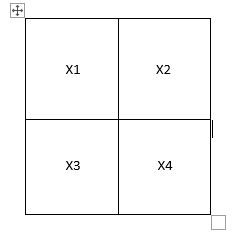

To input these into our net, we also have to *flatten* the image into a vector of length *h x w* so our above example would be 2x2 = 4

When we implement our batch size, the input to our net will be the batch size [batch size, vector]. So if we had 10 images of 2x2, the input to our net would be [10,4]. We can flatten our images during the *forward* function of our net as the very first stage. Using either:



or torch.flatten()

### Labels and One-Hot Encoding

If we have 3 classes, dog, cat and chicken, we need to find a way to label them for our net. 

The best way of doing this is **one-hot encoding**. In this we create a vector for each class, with the number of components corresponding to the number of classes. 

The component that corresponds to a certain class is set to 1, all others are set to 0.  

For example, dog = $\begin{bmatrix}
           1 \\
           0 \\
           0
         \end{bmatrix}$, cat = $\begin{bmatrix}
           0 \\
           1 \\
           0
         \end{bmatrix}$, and chicken = $\begin{bmatrix}
           0 \\
           0 \\
           1
         \end{bmatrix}$

I'm fairly sure that like above, these should be stored as column vectors [number of rows, 1].

In [20]:
dog = np.array([[1,0,0]]).reshape(-1,1)
dog

array([[1],
       [0],
       [0]])

To find what index is being set to 1 and therefore what class a vector corresponds to, we use argmax()

In [21]:
print('Highest index = ' + str(dog.argmax()))

Highest index = 0


### Architecture

Within this specific net, we are again using a fully-connected model. This means that all outputs are connected to all inputs: 

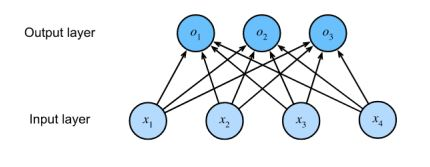

We have the **same number of outputs as number of classes**. 

We can imagine that each output of this net corresponds to a value within our y vector. 

For example, our model might output: 

$o_1 = 0.72 \\ 
o_2 = 0.85 \\
o_3 = -0.32$

If we combine this into a vector it would look like: $\begin{bmatrix}
           0.72 \\
           0.85 \\
           -0.32
         \end{bmatrix}$
         
The location of the maximum value indicates the predicted class. Take note that this is before the softmax operation has been applied. At this stage they are considered *logits*. They are not exactly ones and zeros. Also, they should not be considered probabilities as they *do not sum to 1* and can *also be negative values*.   

As we have 4 features [x1,x2,x3,x4], we must compute **for every output** a linear combination of 4 weights with these 4 features, + a bias. 

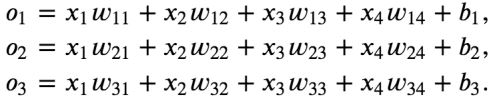

We can simplify this into linear algebra with the notation: $\boldsymbol{o} = \boldsymbol{x}\boldsymbol{W}^T+\boldsymbol{b}$

All features are gather in vector $\boldsymbol{x}$

All weights are in 3x4 matrix $\boldsymbol{W}$

All biases are in vector $\boldsymbol{b}$

All outputs are in vector $\boldsymbol{o}$

Our x vector is [1,number of features]. When put in as batches though, it is [number of batches, number of features] 


In [22]:
x_vec = np.array([0.5,0.3,0.4,0.7]).reshape(1,-1)
x_vec

array([[0.5, 0.3, 0.4, 0.7]])

Our weights matrix is [number of classes (outputs), number of features (inputs)] = 3x4. To multiply it with our x vector, we have to transpose it to shape (4x3)

In [23]:
W_mat = np.array([[0.23,0.35,0.42,0.15],
                  [0.42,0.64,0.72,0.45],
                  [0.14,0.55,0.26,0.75]])
W_mat.T

array([[0.23, 0.42, 0.14],
       [0.35, 0.64, 0.55],
       [0.42, 0.72, 0.26],
       [0.15, 0.45, 0.75]])

Our bias vector is simply [1,number of classes (outputs)] = 1x3

In [24]:
b_vec = np.array([0.12,0.42,0.52]).reshape(1,-1)
b_vec

array([[0.12, 0.42, 0.52]])

Our output matrix is [1,number of classes (outputs)]

In [25]:
o_vec = x_vec@W_mat.T+b_vec
o_vec

array([[0.613, 1.425, 1.384]])

#### Softmax Example

Using the output values from the $\boldsymbol{o}$ vector above:

In [26]:
np.exp(0.613)/(np.exp(0.613) + np.exp(1.425) + np.exp(1.384))

0.18469487495685094

In [27]:
np.exp(1.425)/(np.exp(0.613) + np.exp(1.425) + np.exp(1.384))

0.4160082695907602

In [28]:
np.exp(1.384)/(np.exp(0.613) + np.exp(1.425) + np.exp(1.384))

0.39929685545238874

In [29]:
0.18469487495685094 + 0.4160082695907602 + 0.39929685545238874

1.0

This results in new vector: 

In [30]:
o_soft = np.array([np.exp(0.613)/(np.exp(0.613) + np.exp(1.425) + np.exp(1.384)), 
                   np.exp(1.425)/(np.exp(0.613) + np.exp(1.425) + np.exp(1.384)), 
                   np.exp(1.384)/(np.exp(0.613) + np.exp(1.425) + np.exp(1.384))]).reshape(1,-1)
o_soft

array([[0.18469487, 0.41600827, 0.39929686]])

All the values are non-negative and sum to 1. We can now interpret these values as probabilities and select the highest probability as our predicted class (using argmax). 

Although softmax is a non-linear function, the outputs are still determined by a linear transformation of input features, therefore it is a linear model. 

### Using Batches

The previous example was only for one image. Introducing batches results in the equation: 

$\boldsymbol{O} = \boldsymbol{X}\boldsymbol{W}^T + \boldsymbol{b}$

This creates an output **matrix**, where each **row** corresponds to the image outputs. 

I'll recreate the above example, but using a batch of 2 images

Our X matrix shape in this case is [2,4,1]. But when put into our neural net we can flatten it using torch.flatten(X_mat,start_dim=1) to reduce it to [2,4] which will still work.

In [31]:
X_mat = torch.tensor([[[0.5],
       [0.3],
       [0.4],
       [0.7]],
                     [[0.2],
       [0.6],
       [0.1],
       [0.9]]]).flatten(start_dim=1)
#X_mat = torch.flatten(X_mat,start_dim=1)
print(X_mat)
print('X matrix shape = ' + str(X_mat.shape))

tensor([[0.5000, 0.3000, 0.4000, 0.7000],
        [0.2000, 0.6000, 0.1000, 0.9000]])
X matrix shape = torch.Size([2, 4])


We use the same weight matrix as above. Remember, we are applying the same weights to every image in our minibatch, then when we complete the minibatch we update the weights in regards to the partial derivative of the loss in respect to the parameters. 

In [32]:
W_mat2 = torch.from_numpy(W_mat).to(dtype=torch.float32)
W_mat2.T

tensor([[0.2300, 0.4200, 0.1400],
        [0.3500, 0.6400, 0.5500],
        [0.4200, 0.7200, 0.2600],
        [0.1500, 0.4500, 0.7500]])

We multiply these matrices together with $\boldsymbol{X} \boldsymbol{W}^T$

For matrices to multiply together, they must have the same number of columns as the other has rows. 

When multiplying our X matrix of [2,4] and the W_mat2.T of [4,3]:
We have 4 columns in X matrix and 4 rows in Weight matrix, therefore they can multiply together to create a 3x2 tensor (number of columns of our Weights matrix x number of rows of X matrix, I think). 

This results in our output $\boldsymbol{O}$ tensor.

In [33]:
O_mat = X_mat@W_mat2.T + b_vec
O_mat.to(dtype=torch.float32)

tensor([[0.6130, 1.4250, 1.3840],
        [0.5530, 1.3650, 1.5790]])

Applying softmax to this results in each row corresponding to a single image output, with probabilities summing to 1. 

In [34]:
softmax = nn.Softmax(dim=1)
O_soft = softmax(O_mat).to(dtype=torch.float32)
O_soft

tensor([[0.1847, 0.4160, 0.3993],
        [0.1655, 0.3728, 0.4617]])

#### Dimensions

Assuming a minibatch of $\boldsymbol{X}$ with feature dimensionality *d* and batch size $\beta$:

$\boldsymbol{X} \in \mathbb{R}^{\beta \times d}$ = 2x4

With number of output classes q: 

$\boldsymbol{W} \in \mathbb{R}^{q \times d}$ = 3x4 but remember to transpose to 4x3

$\boldsymbol{q} \in \mathbb{R}^{1 \times q}$ = 1x3

$\boldsymbol{O} = \boldsymbol{X}\boldsymbol{W}^T + \boldsymbol{b}$

$\boldsymbol{\hat{Y}} = $ SOFTMAX $\boldsymbol{O}$

### Loss Function - Cross Entropy Loss

We can calculate the dissimilarity between our $\hat{y}$ and y label vectors using: 

e = $\hat{y}$ - y

distance (dissimilarity) = $e^T\cdot e$

Let's use the first example from our predictions: $\hat{y} = $ [0.1847, 0.4160, 0.3993] and y = [0,1,0]

In [35]:
Y_hat_soft = np.array([0.1847, 0.4160, 0.3993])
y_soft = np.array([0,1,0])

e = Y_hat_soft - y_soft
e

array([ 0.1847, -0.584 ,  0.3993])

If we were to change our y label into [1,0,0] or [0,0,1], we find the distance is higher than the value below. This shows that we have correctly predicted the true label as our prediction has the lowest **dissimilarity**. 

What we want to do is minimise this distance or **maximise similarity**

In [36]:
print('dissimilarity = ' + str(e.T@e))

dissimilarity = 0.5346105800000001


To find the similarity between two vectors, we simply find the dot product: $\hat{y}^T \cdot y$

By doing this, we are multiplying 0.1847 by 0, 0.4160 by 1 and 0.3993 by 0, we then sum these values. This leaves us with one value of 0.4160 which again is the highest similarity. If our y labels were [1,0,0] or [0,0,1] then the similarity is lower. What we want to do is maximise this similarity value which essentially means maximising our predicted probability. (This is the Maximum Likelihood criteria)

In [37]:
Y_hat_soft.T@y_soft

0.416

At this point we introduce a concept found in machine learning of **negative log-likelihood**.

Firstly, if we want to maximise **s**, then we want to minimise **negative s** ($-s$)

$-s = -\hat{y}^T\cdot y$

We also introduce the logs to our $\hat{y}$ vector

$\hat{y} = [\log \hat{y}_1,\log \hat{y}_2,\log \hat{y}_3]$

This results in $-[\log \hat{y}]^T\cdot y$

In [38]:
-np.log(Y_hat_soft).T@y_soft

0.8770700187208739

We then calculate this for all prediction $\hat{y}$ and y vectors and sum the values. Our final formula is: 

$-\Sigma \log\hat{y}\cdot y$

Let's perform this on our tensors

In [39]:
y_tensor = torch.tensor([[0,1,0],
                         [0,0,1]]).to(dtype=torch.float32)
y_tensor

tensor([[0., 1., 0.],
        [0., 0., 1.]])

In [40]:
-torch.log(O_soft)

tensor([[1.6891, 0.8771, 0.9181],
        [1.7988, 0.9868, 0.7728]])

The way we have implemented this means that there is no transpose needed for a batch example. 

This is because our y tensor is one hot encoded. Therefore, we just multiply (not using matrix multiplication) our y tensor and predicted y tensor of negative logs. This means the only values kept are the indices in the predicted y tensor that have a 1 in the true y tensor. 

We can then sum these values to generate our final cross entropy loss for all inputs in our batch.

Our goal is to minimise this value! 

In [41]:
torch.sum(-torch.log(O_soft)*y_tensor)

tensor(1.6498)

When we actually use this loss in pytorch, it expects the y labels to be put as the index of the class in a one-hot encoded format. e.g the two examples above would be a tensor of [1,2] 

It also expects the outputs of our model to just be logits, it automatically performs the softmax operation for us. 

### Example with Fashion Dataset

Using the fashion dataset loader from the my_utils.py file.

All the pixel values are normalised between 0 and 1.

The X input shape is [256,1,28,28]. This is batch size, by channel (greyscale), by height and width in pixels. What we want to do is flatten these to [256,784] (28x28)

The y label tensor contains the index value of the true class for each training image. 

In [42]:
batch_size2 = 256
train_iter2, test_iter2 = mu.load_data_fashion_mnist(batch_size2)

In [43]:
# full_train, full_test = mu.load_data_fashion_mnist(50000)
# full_train_X, train_labels = next(iter(full_train))
# full_test_X, test_labels = next(iter(full_test))

In [44]:
X_f, y_f = next(iter(train_iter2))
y_f

tensor([5, 9, 7, 9, 2, 6, 2, 8, 1, 2, 4, 4, 9, 7, 6, 3, 5, 6, 3, 1, 1, 9, 5, 8,
        3, 8, 9, 4, 2, 4, 3, 5, 1, 4, 8, 2, 1, 5, 2, 0, 0, 1, 5, 0, 9, 3, 9, 4,
        5, 7, 1, 3, 1, 7, 9, 0, 9, 4, 7, 0, 2, 4, 4, 8, 1, 9, 7, 2, 1, 1, 4, 4,
        4, 5, 3, 3, 7, 9, 0, 4, 3, 6, 3, 5, 2, 7, 7, 9, 9, 6, 6, 1, 4, 0, 1, 5,
        3, 5, 3, 5, 2, 6, 9, 0, 2, 1, 0, 3, 2, 0, 4, 6, 9, 1, 4, 4, 2, 4, 6, 3,
        6, 0, 4, 3, 0, 9, 6, 3, 6, 3, 4, 2, 3, 5, 4, 8, 6, 8, 5, 7, 6, 7, 8, 1,
        9, 5, 3, 6, 1, 2, 3, 7, 7, 9, 0, 6, 0, 1, 3, 5, 4, 4, 1, 1, 8, 0, 9, 0,
        1, 4, 4, 1, 2, 6, 9, 0, 3, 2, 1, 6, 5, 3, 6, 3, 3, 7, 0, 1, 2, 6, 4, 7,
        9, 0, 9, 9, 2, 7, 0, 9, 2, 8, 3, 7, 3, 0, 1, 7, 4, 8, 3, 9, 0, 9, 1, 0,
        6, 9, 8, 9, 8, 8, 3, 7, 2, 0, 8, 4, 2, 6, 4, 8, 1, 7, 4, 1, 7, 6, 9, 6,
        6, 0, 1, 6, 0, 8, 8, 2, 5, 7, 2, 4, 9, 3, 2, 5])

In [45]:
torch.flatten(X_f,start_dim=1).shape

torch.Size([256, 784])

In [46]:
net2 = nn.Linear(784,10)

In [47]:
optimizer2 = torch.optim.SGD(net2.parameters(),lr=0.1)
CEloss = nn.CrossEntropyLoss()

This is a test with just a single linear layer for classification. It takes some time to run but the results are below. We can see that it does work as the loss decreases but it is a bit bumpy, with increases taking place here and there. 

Usually, we would take the loss over the entire dataset but due to how loading the data through my_utils works I can only split into train and test. Therefore, I've just taken the loss over the full train dataset which is still 50,000 images. 

I have also calculated the accuracy values using the my_utils function. It only returns the number of correctly identified labels so to get a percentage you have to divide by total number of input images then multiply by 100. The train and test accuracies are quite close together so it does not appear to have overfit. 

In [48]:
num_epochs2=10
# for epoch in range(num_epochs):
#     for X,y in train_iter2:
#         y_hat = net2(torch.flatten(X,start_dim=1))
#         l = CEloss(y_hat,y)
#         optimizer2.zero_grad()
#         l.backward()
#         optimizer2.step()
#     l = CEloss(net2(torch.flatten(full_train_X,start_dim=1)),train_labels)
#     train_acc = (mu.accuracy(net2(torch.flatten(full_train_X,start_dim=1)),train_labels))/50000*100
#     test_acc = (mu.accuracy(net2(torch.flatten(full_test_X,start_dim=1)),test_labels))/10000*100
#     print(f'epoch {epoch+1}, loss {l:f}, train accuracy {train_acc:f}, test_accuracy {test_acc:f}')

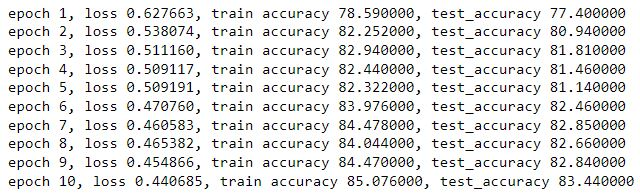

To get it to work with the train_ch3 function we have to include the flatten() function within the net itself. This is simple to do using nn.Sequential which executes and feeds each layer into the next automatically. 

In [49]:
net3 = nn.Sequential(
    nn.Flatten(start_dim=1),
    nn.Linear(784,10)
)

In [50]:
optimizer3 = torch.optim.SGD(net3.parameters(),lr=0.1)

This graph just displays (approximately) the results from the version above. 

In [51]:
#mu.train_ch3(net3, train_iter2, test_iter2, CEloss, num_epochs2, optimizer3)

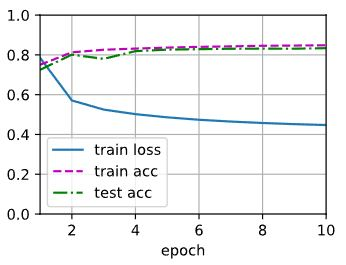

## MLPS (Multi-Layer Perceptrons)

If our labels are associated to our data by a linear function, then we can simply use a linear model to make predictions. 

However, this linearity is a **strong assumption**. Not all data and labels are linearly related.

An increase of income from 0 to 50000 will tell you more about the possibility of repayment of a loan than an increase from 1 to 1.05 million. 

A way of dealing with this could be to preprocess (feature engineering) the data in such a way as to make it linearly plausible. e.g use the logs of the income data. This feature engineering requires domain expertise in knowing which features to extract from the data. 

Other examples include taking the mean, standard deviation, median, or difference between each feature. e.g x1 - x2, x2 - x3.

These features can be made into a feature vector: $\begin{bmatrix}
           f_1 \\
           f_2 \\
           f_3
         \end{bmatrix}$ This is then fed into the neural network instead of the original input data. 

For a classification problem, the connection is less immediately obvious. Is there a linear relationship between the brightness of pixels and the probability that an image is a cat or dog? 

Using MLPS, we can extract features from our input data and feed these to a classifier that acts upon them to output predictions.

### Structure

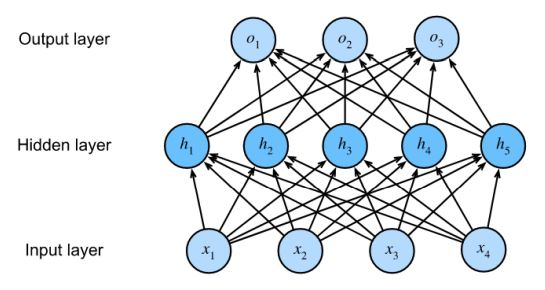

We construct MLPS within **fully connected linear layers**. That is, all outputs are connected to all inputs of the layers above and below. 

The above MLP contains 4 inputs, 5 hidden units and 3 outputs (classifier). 

It contains 2 layers, the first layer being the hidden layer which generates the features and the last layer being the output layer which classifies them. 

(Testing concatenation to create a weights tensor for generating hidden layer)

Below is the original weights tensor for generating 3 outputs

In [77]:
W_hidden = W_mat2.clone()
W_hidden

tensor([[0.2300, 0.3500, 0.4200, 0.1500],
        [0.4200, 0.6400, 0.7200, 0.4500],
        [0.1400, 0.5500, 0.2600, 0.7500]])

In [74]:
#test_cat = torch.tensor([0.42,0.52,0.62]).reshape(3,1)
test_cat2 = torch.tensor([[0.12,0.22,0.32,0.42],
                        [0.24,0.64,0.73,0.16]]).reshape(2,-1)
#test_cat

In [78]:
#W_hidden = torch.cat((W_hidden,test_cat),1)
W_hidden = torch.cat((W_hidden,test_cat2),0)

Remember that our $H_1$ output would look like:

$H_1 = x_1w_{11} + x_2w_{12} + x_3w_{13} + x_4w_{14}$ 

We are simply adding another set of weights to our weight matrix. In this case:

$w_{11} = 0.23, w_{12} = 0.35, w_{13} = 0.42, w_{14} = 0.15$

However, H goes from $H_1 \rightarrow H_5$

In [86]:
W_hidden

tensor([[0.2300, 0.3500, 0.4200, 0.1500],
        [0.4200, 0.6400, 0.7200, 0.4500],
        [0.1400, 0.5500, 0.2600, 0.7500],
        [0.1200, 0.2200, 0.3200, 0.4200],
        [0.2400, 0.6400, 0.7300, 0.1600]])

In [81]:
X_mat

tensor([[0.5000, 0.3000, 0.4000, 0.7000],
        [0.2000, 0.6000, 0.1000, 0.9000]])

To multiply together, we have to remember to transpose our weights matrix

In [83]:
hidden_vals = X_mat@W_hidden.T
hidden_vals

tensor([[0.4930, 1.0050, 0.8640, 0.5480, 0.7160],
        [0.4330, 0.9450, 1.0590, 0.5660, 0.6490]])

With our hidden values, we then need weights that will create the 3 outputs. 

This is the same as: 

$o_1 = h_1w_{11} + h_2w_{12} + h_3w_{13} + h_4w_{14} + h_5w_{15}$

So $O = HW^T (+b)$

In [88]:
W_out2 = torch.rand(3,5,generator=torch.Generator().manual_seed(42))
W_out2

tensor([[0.8823, 0.9150, 0.3829, 0.9593, 0.3904],
        [0.6009, 0.2566, 0.7936, 0.9408, 0.1332],
        [0.9346, 0.5936, 0.8694, 0.5677, 0.7411]])

Remember the transposition!

In [71]:
hidden_vals@W_out2.T

tensor([[2.4560, 1.9041, 2.6327],
        [2.4192, 1.9242, 2.6475]])

### Adding Non-Linearities

No matter how many linear layers we stack upon one another, we still can reduce this to the linear function $o = XW + b$

In order to capture non-linear patterns, we have to introduce non-linear activation functions. With these in place, we can no longer collapse an MLP into a linear model.

$H = \sigma(XW + b)\\
O = HW + b$

To build on this, we can stack MLPs to create even more expressive functions

### Activation Functions

These decide whether neurons should be fired. They are also differentiable. 

#### ReLU (Rectified Linear Unit) 

These are very popular and are equivalent to a max(x,0) function. 

In essence, if a feature is greater than 0, the feature passes through and the derivative = 1. If the feature is below or equal to 0, then the resulting gradient is set to 0. 

Be advised that although both these graphs show relu, the gradient is what we are interested in which is displayed within the second graph. 

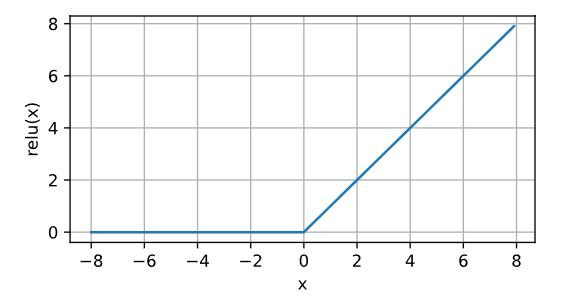

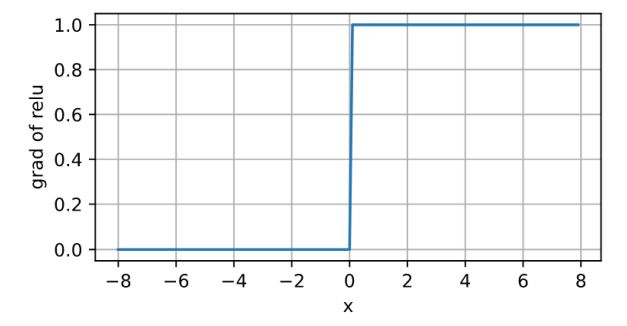

If we have the output of a hidden layer H = [-0.5,-3,2,4,5] which is then fed to a ReLU activation function. The resulting output would be [0,0,2,4,5].

This is useful as it either lets features through or does not. Hence there is no issue of vanishing gradient and the network is able to learn faster. 

ReLU also creates more sparse representations, if all values below 0 are set to 0 then this results in sparse outputs. Other activation functions will output values less than 0 which are called dense outputs. It appears to be better to have sparse rather than dense outputs. 

A minor issue with relu is that all values below 0 are all set to the same value of 0. This results in information loss. A couple of versions of relu such as parameterised relu and leaky relu allow a small amount of information to get through even when the input is less than 0. 

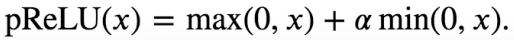

This $\alpha$ value can be learned and also vary between pReLU layers 

#### Sigmoid 

The sigmoid is used to squash input values between [0,1]. (Input on the x axis)

It is an approximation of modeling biological neurons and a differentiable version of the non-differentiable step function.

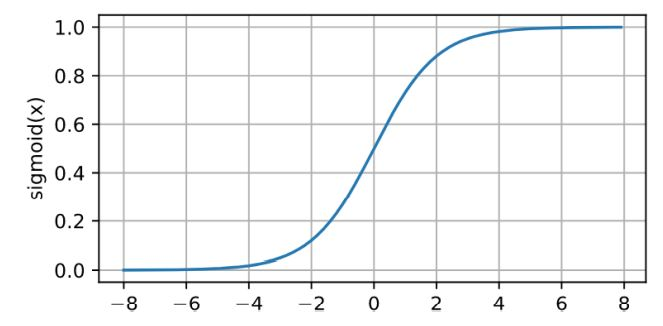

What we can observe is that as inputs get further away from 0, the resulting gradient gets very small. This issue is known as the vanishing gradient and is especially prevalent in networks with more layers. The first layer will make the gradient small, the next will make it even smaller etc. If the gradients are too small, you don't learn anything. 

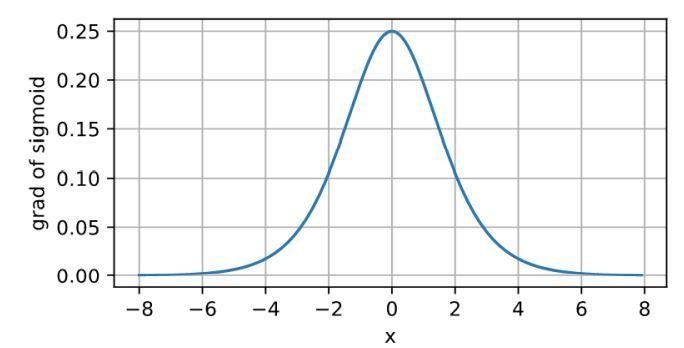